In [9]:
import pandas as pd
from indicators import RSI, extract_bb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import numpy as np
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import clear_output
import plotly.graph_objects as go
import plotly.express as px

warnings.filterwarnings("ignore")

In [8]:
pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 9.3 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
df = pd.read_csv("gzpn_data.csv")
df = df.dropna().sample(frac=1).reset_index(drop=True)
df = df.drop(columns=["<TICKER>", "<PER>", "<DATE>", "<TIME>"])
df.columns = ["open", "high", "low", "close", "volume"]
df

,open,high,low,close,volume
0,168.18,168.18,168.03,168.07,35390
1,166.28,166.29,166.20,166.21,202120
2,166.20,166.31,166.20,166.30,22990
3,164.13,164.13,164.03,164.04,13120
4,166.23,166.23,166.03,166.13,84960
...,...,...,...,...,...
2128,163.28,163.38,163.26,163.38,45040
2129,167.89,167.89,167.78,167.80,21310
2130,163.59,163.60,163.50,163.54,91250
2131,166.72,166.75,166.47,166.49,105300


In [ ]:
n_steps = 11

prices = df["close"]

rsi_values = RSI(prices=prices, n_steps=n_steps)
bb_values = extract_bb(prices=prices, n_steps=n_steps)

assert len(rsi_values) == len(
    bb_values
), f"Indicators length don't coincide: {len(rsi_values)} and {len(bb_values)}"

In [ ]:
def prepare_target(df, steps_obs: int = 3):
    targets = []
    for i in range(0, len(df) - steps_obs):
        current_price = df["close"].iloc[i]
        max_price = df["high"].iloc[i + 1 : i + 1 + steps_obs].max()
        targets.append(max_price > current_price)
    targets += [0] * steps_obs
    return np.array(targets, dtype=np.int32)


steps_obs = 3

targets = prepare_target(df=df, steps_obs=steps_obs)

In [ ]:
indicator_data = (
    pd.DataFrame(
        data=np.array([rsi_values, bb_values, targets]).T,
        columns=["rsi", "bb", "target"],
    )
    .dropna()
    .reset_index(drop=True)
    .astype(np.float64)
)
indicator_data["target"] = indicator_data["target"].astype(np.int32)
indicator_data

,rsi,bb,target
0,42.566510,-1.228299,1
1,51.131824,1.174911,1
2,50.086957,-0.663223,1
3,53.951063,1.827532,0
4,55.578512,0.528205,1
...,...,...,...
2117,44.632153,-1.456529,1
2118,48.030691,0.905347,0
2119,41.938365,-1.435991,0
2120,46.058091,0.306427,0


In [ ]:
indicator_data.describe()

,rsi,bb,target
count,2122.000000,2122.000000,2122.000000
mean,50.023984,-0.003008,0.764373
std,6.856173,0.947829,0.424490
min,14.791667,-1.935489,0.000000
25%,45.356781,-0.828638,1.000000
50%,50.000000,-0.188444,1.000000
75%,54.885700,0.803437,1.000000
max,79.097744,2.526117,1.000000


In [ ]:
all_data = indicator_data.copy()
all_data[df.columns] = df.iloc[n_steps:, :].values

all_data

,rsi,bb,target,open,high,low,close,volume
0,42.566510,-1.228299,1,163.36,163.36,163.28,163.36,177090.0
1,51.131824,1.174911,1,166.70,166.81,166.66,166.81,27390.0
2,50.086957,-0.663223,1,164.00,164.08,163.97,164.08,7740.0
3,53.951063,1.827532,0,168.07,168.15,168.03,168.10,31330.0
4,55.578512,0.528205,1,165.84,166.20,165.83,166.17,246030.0
...,...,...,...,...,...,...,...,...
2117,44.632153,-1.456529,1,163.28,163.38,163.26,163.38,45040.0
2118,48.030691,0.905347,0,167.89,167.89,167.78,167.80,21310.0
2119,41.938365,-1.435991,0,163.59,163.60,163.50,163.54,91250.0
2120,46.058091,0.306427,0,166.72,166.75,166.47,166.49,105300.0


# Обработка фичей

In [ ]:
scaler = MinMaxScaler()
scaler.fit(indicator_data.iloc[:, :-1])
indicator_data.iloc[:, :-1] = scaler.transform(indicator_data.iloc[:, :-1])
indicator_data

,rsi,bb,target
0,0.431916,0.158506,1
1,0.565112,0.697148,1
2,0.548864,0.285159,1
3,0.608953,0.843423,0
4,0.634261,0.552199,1
...,...,...,...
2117,0.464038,0.107351,1
2118,0.516888,0.636730,0
2119,0.422148,0.111955,0
2120,0.486213,0.502491,0


In [ ]:
indicator_data[["rsi", "bb"]].iloc[1].values

array([0.56511233, 0.69714802])

In [ ]:
X = indicator_data.iloc[:, :]
y = indicator_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, shuffle=False
)

## Reccurent neural network

In [10]:
X_train = torch.Tensor(X_train.values)
y_train = torch.Tensor(y_train.values).reshape(-1, 1)
X_test = torch.Tensor(X_test.values)
y_test = torch.Tensor(y_test.values).reshape(-1, 1)

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
def prepare_input(data, sequence_length):
    """
    Prepare input data for an RNN by creating sequences of fixed length.

    Args:
    - data (torch.Tensor): 1D tensor containing the input data.
    - sequence_length (int): Length of each sequence.

    Returns:
    - torch.Tensor: 3D tensor containing the input data in suitable format for RNN.
    """
    input_sequences = []
    for i in range(len(data) - sequence_length + 1):
        input_seq = data[i : i + sequence_length]
        input_sequences.append(input_seq)
    return torch.stack(input_sequences)


sequence_length = 3
X_train_rnn = prepare_input(X_train, sequence_length)
y_train_rnn = y_train[sequence_length - 1 :]

X_test_rnn = prepare_input(X_test, sequence_length)
y_test_rnn = y_test[sequence_length - 1 :]

In [13]:
y_train_rnn.shape, X_train_rnn.shape

(torch.Size([1695, 1]), torch.Size([1695, 3, 2]))

In [14]:
# Define a simple neural network
class SequentialModel(nn.Module):
    def __init__(
        self,
        input_size: int = 2,
        hidden_size: int = 8,
        output_size: int = 1,
        rnn_layers: int = 2,
        n_layers: int = 2,
        dropout: float = 0.1,
        input_layer_type=nn.RNN,
    ):
        super(SequentialModel, self).__init__()
        self.rnn_layer = input_layer_type(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=rnn_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fcc_layers = []
        for i in range(n_layers):
            self.fcc_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        rnn_output, h0 = self.rnn_layer(x)
        x = torch.relu(rnn_output[:, -1, :])
        for fcc_layer in self.fcc_layers:
            x = torch.relu(fcc_layer(x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x


# data_num = 1024
# Generate some random data
# X = torch.Tensor(X)
# y = torch.Tensor(y).reshape(-1,1)

batch_size = 256
dataset_train = TensorDataset(X_train_rnn, y_train_rnn)
dataset_test = TensorDataset(X_test_rnn, y_test_rnn)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = SequentialModel(
    input_size=2,
    hidden_size=4,
    rnn_layers=3,
    n_layers=2,
    output_size=1,
    dropout=0.1,
    input_layer_type=nn.RNN,
)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

count_parameters(model)

117

In [21]:
# Training loop
def train_model(model, epochs=200):
    print("New model started training!")
    for epoch in range(epochs):
        loss_train = []

        for inputs, labels in dataloader_train:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            loss_train.append(loss.item())
            optimizer.step()

        if epoch % 100 == 0:
            loss_test = []
            for inputs, labels in dataloader_test:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss_test.append(loss.item())
                optimizer.step()
            print(
                f"Epoch [{epoch+1}/{epochs}], Loss_train: {np.mean(loss_train):.4f}, Loss_test: {np.mean(loss_test):.4f}"
            )
    final_loss = np.mean(loss_test)
    print(f"Ready! Final loss: {final_loss}")
    clear_output()
    return final_loss

In [26]:
# parameters_dict = dict()

# for hidden_size in [3, 5, 7, 8]:
#     for rnn_style in [nn.RNN, nn.GRU]:
#         for n_layer in [2, 4, 6]:
#             model = SequentialModel(
#                 input_size=2,
#                 hidden_size=hidden_size,
#                 rnn_layers=2,
#                 n_layers=n_layer,
#                 output_size=1,
#                 dropout=0.2,
#                 input_layer_type=rnn_style,
#             )
#             res = train_model(model, epochs=1200)
#             parameters_dict[(hidden_size, rnn_style, n_layer)] = res


# Save the trained model
# torch.save(model.state_dict(), 'simple_model.pth')

In [23]:
model = SequentialModel(
    input_size=2,
    hidden_size=6,
    rnn_layers=2,
    n_layers=2,
    output_size=1,
    dropout=0.2,
    input_layer_type=nn.RNN,
)
res = train_model(model, epochs=1200)

In [30]:
# Собираем вместе все данные

y_pred = torch.sigmoid(model(X_test_rnn)).T[0].detach().numpy()
print(len(y_pred))
test_prices = df.iloc[]

423


array([0.48289207, 0.49171916, 0.48434538, 0.4818354 , 0.49042454,
       0.4757252 , 0.4756102 , 0.47925428, 0.48108092, 0.49599296,
       0.50336343, 0.47588325, 0.4910559 , 0.48464203, 0.498937  ,
       0.48385406, 0.49337173, 0.4823302 , 0.5051695 , 0.4925246 ,
       0.4773228 , 0.47869602, 0.48490414, 0.48903054, 0.48435125,
       0.48971248, 0.4854227 , 0.47939187, 0.488855  , 0.5102887 ,
       0.48491767, 0.50604296, 0.48573604, 0.48784897, 0.5069868 ,
       0.48847416, 0.49384877, 0.47464365, 0.51301926, 0.48806584,
       0.49764916, 0.49083892, 0.4993389 , 0.48630106, 0.4835228 ,
       0.49539402, 0.48599398, 0.48159242, 0.49046138, 0.48534596,
       0.49533698, 0.4838616 , 0.47511604, 0.5135093 , 0.4900063 ,
       0.48364976, 0.47876367, 0.5029655 , 0.47444355, 0.48447898,
       0.49774596, 0.51052403, 0.4931579 , 0.48797056, 0.48730204,
       0.4961907 , 0.5054474 , 0.51244307, 0.4751256 , 0.49125192,
       0.49912143, 0.4854019 , 0.4731048 , 0.48266467, 0.46873

In [ ]:
step_data = df.iloc[:50]
x = step_data.index
price = step_data["close"]

x_buy = np.array([i for i in x[::2]])
y_buy = price[x_buy]

In [41]:
fig = px.line(all_data, x=all_data.index, y="close", hover_data=["rsi", "bb"])
fig.update_traces(mode="markers+lines")

fig.show()

In [19]:
fig = px.scatter(
    x=x_buy, y=y_buy, title="Using The add_trace() method With A Plotly Express Figure"
)

fig.add_trace(
    go.Scatter(
        x=x, y=price, mode="lines", line=go.scatter.Line(color="gray"), showlegend=False
    )
)
fig.show()

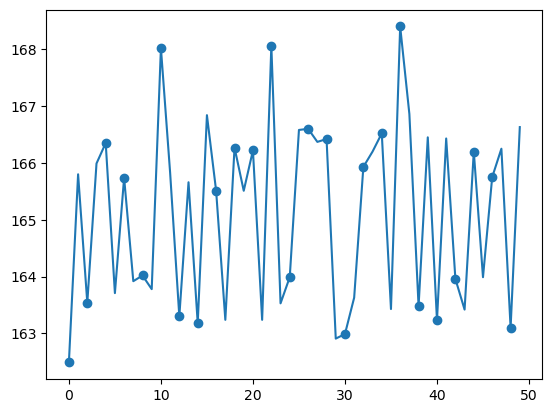

In [15]:
import matplotlib.pyplot as plt


plt.plot(x, price)
plt.scatter(x_buy, y_buy)

In [12]:
all_data

,rsi,bb,target,open,high,low,close,volume
0,42.566510,-1.228299,1,163.36,163.36,163.28,163.36,177090.0
1,51.131824,1.174911,1,166.70,166.81,166.66,166.81,27390.0
2,50.086957,-0.663223,1,164.00,164.08,163.97,164.08,7740.0
3,53.951063,1.827532,0,168.07,168.15,168.03,168.10,31330.0
4,55.578512,0.528205,1,165.84,166.20,165.83,166.17,246030.0
...,...,...,...,...,...,...,...,...
2117,44.632153,-1.456529,1,163.28,163.38,163.26,163.38,45040.0
2118,48.030691,0.905347,0,167.89,167.89,167.78,167.80,21310.0
2119,41.938365,-1.435991,0,163.59,163.60,163.50,163.54,91250.0
2120,46.058091,0.306427,0,166.72,166.75,166.47,166.49,105300.0


In [45]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from gym import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import ProgressBarCallback

# Your DataFrame `df` should contain all observations and you will have your reward function `reward_function`
df = res.copy()
df.columns = [col.lower() for col in df.columns]

steps_obs = 3
commision_bps = 0
rewards = []
Statistics = []

init_balance = 200
init_active = 10

start_price = all_data["close"].iloc[0]
init_pv = init_balance + init_active * start_price

MAX_BALANCE = 2 * init_pv
MAX_ACTIVE = 2 * init_pv / start_price


class CustomEnv(gym.Env):
    def __init__(self, df, init_balance, init_active, test=False):
        super(CustomEnv, self).__init__()
        self.df = df
        self.test = test
        self.seed = lambda x: 0
        self.current_step = 0
        # Assume observation space is a 1D array of features (adjust according to your data)
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.balance = init_balance
        self.active = init_active
        self.current_price = self.df["close"].iloc[self.current_step]
        self.pv = self.balance + self.active * self.current_price
        # Adjust according to your action space
        self.action_space = spaces.Box(
            low=np.array([-1]),
            high=np.array([1]),
            dtype=np.float32,
        )

    def reset(self):
        # Reset the state of the environment to an initial state
        print("reseting...")
        self.current_step = 0
        if self.test:
            rewards.append([])
            Statistics.append([])
        return self.df.iloc[self.current_step, -6:].values

    def reward_function(self, action):
        next_price = self.df["close"].iloc[self.current_step + 1]
        # покупаем
        if action > 0:
            money_to_spend = self.balance * action
            self.active += money_to_spend / self.current_price
            self.balance -= money_to_spend
        # продаем
        elif action < 0:
            active_to_sell = self.active * abs(action)
            self.active -= active_to_sell
            self.balance += active_to_sell * self.current_price
        new_pv = self.active * next_price + self.balance
        reward = (new_pv - self.pv) / self.pv * 1e4

        return reward

    def step(self, action):
        # Calculate the reward

        reward = self.reward_function(action)
        self.current_step += 1
        if self.current_step < len(self.df.index) - (steps_obs + 1):
            next_state = np.append(
                self.df[indicator_data.columns].iloc[self.current_step].values,
                np.array([self.balance / MAX_BALANCE, self.active / MAX_ACTIVE]),
            )
            done = False
        else:
            # The episode is finished
            next_state = np.zeros(self.observation_space.shape)
            done = True

        # Placeholder for info, additional data can be added if needed
        info = {}
        # print(next_state)
        if self.test:
            rewards[-1].append(reward)
        self.current_price = self.df["close"].iloc[self.current_step]
        self.pv = self.active * self.current_price + self.balance

        return next_state, reward, done, info

0.07212937

In [17]:
# Create multiple environments
env = CustomEnv()
env = DummyVecEnv([lambda: env])

# Create the PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=10000, progress_bar=True)

# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

torch.Size([5, 3, 20])